In [1]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

tf.enable_eager_execution()

import os
import numpy as np
import matplotlib.pyplot as plt


DIR = 'train_data/' # train data directory

In [2]:
IMAGE_SIZE_W = 224 # width
IMAGE_SIZE_H = 224 # height
BATCH_SIZE = 32

NUMBER_CLASS = 4 # number of classes

VALIDATION_SPLIT = 0.1 # 10% of the train data

wired_dir = DIR

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_SPLIT)

train_generator = datagen.flow_from_directory(wired_dir,target_size=(IMAGE_SIZE_W, IMAGE_SIZE_H),batch_size=BATCH_SIZE, subset='training')

val_generator = datagen.flow_from_directory(wired_dir,target_size=(IMAGE_SIZE_W, IMAGE_SIZE_H),batch_size=BATCH_SIZE, subset='validation')

Found 1472 images belonging to 4 classes.
Found 163 images belonging to 4 classes.


In [3]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 4))

In [4]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open(DIR + 'wired.txt', 'w') as f:
  f.write(labels)

{'Clip': 0, 'Konektor': 1, 'OTape': 2, 'PTape': 3}


In [5]:
%cd train_data

!cat wired.txt

%cd ../

/home/dimas/Downloads/upload/train_data
Clip
Konektor
OTape
PTape/home/dimas/Downloads/upload


In [6]:
IMG_SHAPE = (IMAGE_SIZE_W, IMAGE_SIZE_H, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False

2023-09-14 21:21:04.909410: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-14 21:21:04.982943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-14 21:21:04.983278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.8095
pciBusID: 0000:01:00.0
2023-09-14 21:21:04.985470: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2023-09-14 21:21:05.019225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2023-09-14 21:21:05.038308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library l

In [7]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=NUMBER_CLASS, activation='softmax')
])
     

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [11]:
history = model.fit_generator(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


2023-09-14 21:21:42.920661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-14 21:21:44.058988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
46/46 [==============================] - 14s 295ms/step - loss: 0.0980 - acc: 0.9708 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2/10
46/46 [==============================] - 12s 261ms/step - loss: 0.0662 - acc: 0.9803 - val_loss: 0.0286 - val_acc: 0.9755
Epoch 3/10
46/46 [==============================] - 12s 261ms/step - loss: 0.0291 - acc: 0.9946 - val_loss: 3.2607e-06 - val_acc: 1.0000
Epoch 4/10
46/46 [==============================] - 12s 261ms/step - loss: 3.3870e-04 - acc: 1.0000 - val_loss: 1.7764e-06 - val_acc: 1.0000
Epoch 5/10
46/46 [==============================] - 12s 261ms/step - loss: 4.8116e-05 - acc: 1.0000 - val_loss: 1.4367e-06 - val_acc: 1.0000
Epoch 6/10
46/46 [==============================] - 12s 261ms/step - loss: 5.8644e-06 - acc: 1.0000 - val_loss: 1.4790e-06 - val_acc: 1.0000
Epoch 7/10
46/46 [==============================] - 12s 262ms/step - loss: 5.0179e-07 - acc

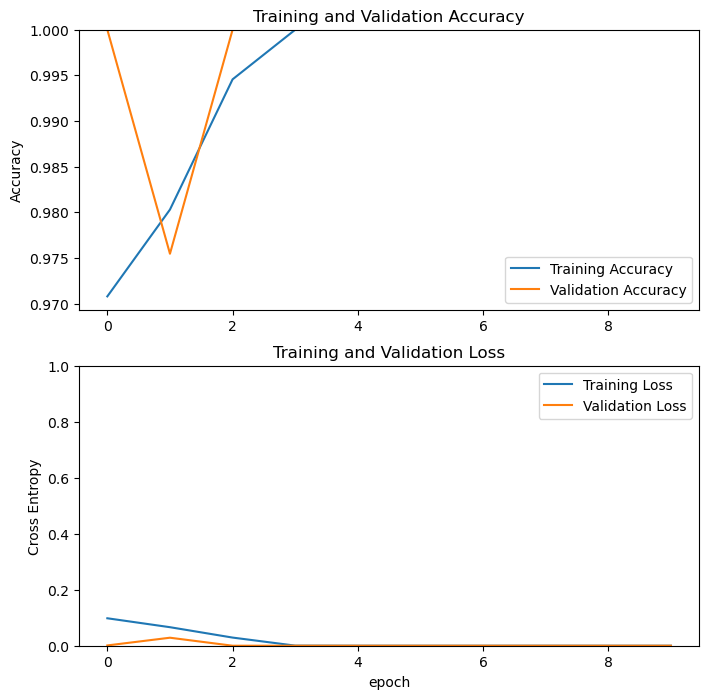

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [14]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
     


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
     

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,231,396
Non-trainable params: 395,392
_________________________________________________________________


In [17]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 60


In [18]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

Epoch 1/5
46/46 [==============================] - 13s 288ms/step - loss: 6.0195e-07 - acc: 1.0000 - val_loss: 2.4376e-06 - val_acc: 1.0000
Epoch 2/5
46/46 [==============================] - 13s 284ms/step - loss: 1.4875e-06 - acc: 1.0000 - val_loss: 2.9865e-06 - val_acc: 1.0000
Epoch 3/5
46/46 [==============================] - 13s 283ms/step - loss: 4.2686e-07 - acc: 1.0000 - val_loss: 3.2386e-06 - val_acc: 1.0000
Epoch 4/5
46/46 [==============================] - 13s 280ms/step - loss: 4.2772e-06 - acc: 1.0000 - val_loss: 8.5061e-07 - val_acc: 1.0000
Epoch 5/5
46/46 [==============================] - 13s 279ms/step - loss: 3.9452e-05 - acc: 1.0000 - val_loss: 1.3342e-06 - val_acc: 1.0000


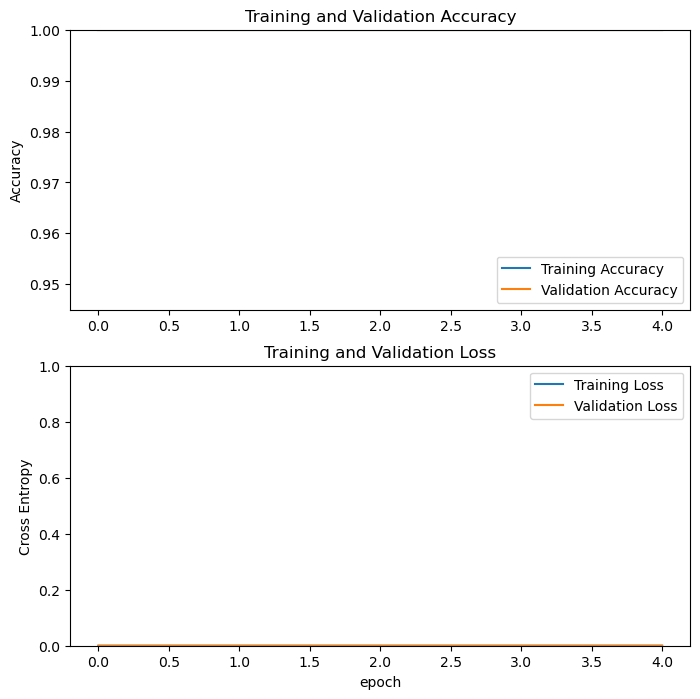

In [19]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
#Convert to TFLite
saved_keras_model = 'model.h5'
model.save(saved_keras_model)

converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('wired.tflite', 'wb') as f:
  f.write(tflite_model)

2023-09-14 21:27:59.680453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-14 21:27:59.680600: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-14 21:27:59.680679: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-09-14 21:27:59.681033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-14 21:27:59.681132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.8095
pciBusID: 0000:01:00.0
2023-09-14 21:27:59.681185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 

In [21]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(wired_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE_W, IMAGE_SIZE_H])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

saved_keras_model = 'model.h5'
model.save(saved_keras_model)

converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# These set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# And this sets the representative dataset so we can quantize the activations
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('wired.tflite', 'wb') as f:
  f.write(tflite_model)

2023-09-14 21:26:05.695102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-14 21:26:05.695251: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-14 21:26:05.695326: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-09-14 21:26:05.695702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-14 21:26:05.695799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.8095
pciBusID: 0000:01:00.0
2023-09-14 21:26:05.695828: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: train_data//*/*'

In [22]:
#Compare the accuracy
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))
     

Raw model accuracy: 100.000%


In [23]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('wired.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

/home/dimas/anaconda3/envs/dimas/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/dimas/anaconda3/envs/dimas/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Quant TF Lite accuracy: 25.000%


In [ ]:
#Compile for the Edge TPU
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	


[sudo] password for dimas:   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0    261      0  0:00:10  0:00:10 --:--:--   618


In [ ]:
! edgetpu_compiler wired.tflite